In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint, simps
import sympy as sm
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import pandas as pd
import emcee
import corner

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from cycler import cycler
sns.set_context("talk", font_scale=1, rc={"lines.linewidth": 2.0, 'lines.markersize': 5})
sns.set_style("ticks")
sns.set_style({"xtick.direction": "in","ytick.direction": "in"})
mpl.rc('axes', prop_cycle=(cycler('color', ['r', 'k', 'b','g','y','m','c','gray']) ))
mpl.rc('text', usetex=False)
#mpl.rc('font',**{'family':'sans-serif','sans-serif':['HelveticaNeueThin']})
#plt.tick_params(top=False, bottom=False, right=False, left=False)
tw = 1.5
sns.set_style({"xtick.major.size": 6, "ytick.major.size": 6,
               "xtick.minor.size": 4, "ytick.minor.size": 4,
               'axes.labelsize': 24,
               'xtick.major.width': tw, 'xtick.minor.width': tw,
               'ytick.major.width': tw, 'ytick.minor.width': tw})
mpl.rc('xtick', labelsize=18)
mpl.rc('ytick', labelsize=18)
mpl.rc('axes', linewidth=1.75)
plt.gcf().subplots_adjust(bottom=0.15)
sns.set_style({'axes.labelsize': 24, 'axes.titlesize': 24})
%matplotlib inline

In [3]:
class hIFFL:
    def __init__(self, m_production, m_degradation, s_production, s_degradation, ms_degradation, c_production, 
                 c_degradation, ci_degradation, k_d):
        self.m_production = m_production
        self.m_degradation = m_degradation
        self.s_production = s_production
        self.s_degradation = s_degradation
        self.ms_degradation = ms_degradation
        self.c_production = c_production
        self.c_degradation = c_degradation
        self.ci_degradation = ci_degradation
        self.k_d = k_d
     
    def model(self, z, t, Temp, noise): #noise is defined as np.random.normal(mean, deviation, len(t))
        c, ci, ct, m, s, ms = z[0], z[1], z[2], z[3], z[4], z[5]
        if Temp == 37:
            dcdt = -c*t
            #-(self.c_production/self.c_degradation)*(1-np.exp(-self.c_degradation*t))
            dcidt = 0 #dcidt = (self.r_production)/(1 + ct/self.k_d) - self.ci_degradation*ci
        else:
            dcdt = self.c_production + (noise) - self.c_degradation*c
            dcidt = 0 #dcidt = -self.ci_degradation*ci
        dctdt = dcdt + dcidt
        dmdt = ((self.m_production)/(1 + (ct)/self.k_d)) - self.m_degradation*m 
        dsdt = ((self.s_production)/(1 + (ct)/self.k_d)) - self.ms_degradation*(m**110/(m**110 + 1))*s - self.s_degradation*s 
        dmsdt = 0 #16.2 * self.s_degradation
        dzdt = [dcdt, dcidt, dctdt, dmdt, dsdt, dmsdt]
        return dzdt
    
    def modulation(self, t, period , off, on): #period * on or period * off must be less than len(t)
        modTemp = []
        for i in range(period):
            while len(t) > len(modTemp):
                for j in range(off):
                    modTemp.append(30)
                for l in range(on):
                    modTemp.append(37)
        return modTemp
            
    def runmodel(self, c, ci, ct, m, s, ms, t, off, on, noise):
        Temp = self.modulation(t, 1, off, on)
        Temp = Temp[0:len(t)]
        z0 = [c, ci, ct, m, s, ms]
        cr = np.empty_like(t)
        cir = np.empty_like(t) 
        ctr = np.empty_like(t)
        mr = np.empty_like(t)
        sr = np.empty_like(t)
        msr = np.empty_like(t)
        cr[0], cir[0], ctr[0], mr[0], sr[0], msr[0] = z0[0], z0[1], z0[2], z0[3], z0[4], z0[5]
        for i in range(1, len(t)):
            tspan = [t[i-1],t[i]]
            z = odeint(self.model,z0,tspan, args =(Temp[i], noise[i]))
            cr[i] = z[1][0]
            cir[i] = z[1][1]
            ctr[i] = z[1][2]
            mr[i] = z[1][3]/(self.m_production/self.m_degradation)
            sr[i] = z[1][4]/(self.s_production/self.s_degradation)
            msr[i] = z[1][5]
            z0 = z[1]
        return[cr.tolist(), cir.tolist(), ctr.tolist(), mr.tolist(), sr.tolist(), msr.tolist(), Temp]


In [4]:
class naive:
    def __init__(self, r_production, s_degradation, c_production, 
                 c_degradation, ci_degradation, k_d):
        self.r_production = r_production
        self.s_degradation = s_degradation
        self.c_production = c_production
        self.c_degradation = c_degradation
        self.ci_degradation = ci_degradation
        self.k_d = k_d
     
    def model(self, z, t, Temp, noise):
        c, ci, ct, s = z[0], z[1], z[2], z[3]
        if Temp == 37:
            dcdt = -c*t
            #-(self.c_production/self.c_degradation)*(1-np.exp(-self.c_degradation*t))
            dcidt = 0# (self.r_production)/(1 + ct/self.k_d) - self.ci_degradation*ci
        else:
            dcdt = self.c_production + (noise) - self.c_degradation*c
            dcidt = 0 #-self.ci_degradation*ci
        dctdt = dcdt + dcidt
        dsdt = ((self.r_production)/(1 + ct/self.k_d)) - self.s_degradation*s
        dzdt = [dcdt, dcidt, dctdt, dsdt]
        return dzdt
    
    def modulation(self, t, period , off, on): #period * on or period * off must be less than len(t)
        modTemp = []
        for i in range(period):
            while len(t) > len(modTemp):
                for j in range(off):
                    modTemp.append(30)
                for l in range(on):
                    modTemp.append(37)
        return modTemp
            
    def runmodel(self, c, ci, ct, s, t, off, on, noise):
        Temp = self.modulation(t, 1, off, on)
        Temp = Temp[0:len(t)]
        z0 = [c, ci, ct, s]
        cr = np.empty_like(t)
        cir = np.empty_like(t)
        ctr = np.empty_like(t)
        sr = np.empty_like(t)
        cr[0], cir[0], ctr[0], sr[0] = z0[0], z0[1], z0[2], z0[3]
        for i in range(1, len(t)):
            tspan = [t[i-1],t[i]]
            z = odeint(self.model,z0,tspan, args =(Temp[i], noise[i]))
            cr[i] = z[1][0]
            cir[i] = z[1][1]
            ctr[i] = z[1][2]
            sr[i] = z[1][3]/(self.r_production/self.s_degradation)
            z0 = z[1]
        return [cr.tolist(), cir.tolist(), ctr.tolist(), sr.tolist(), Temp]



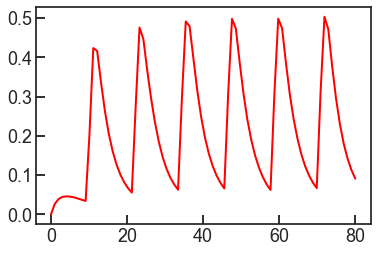

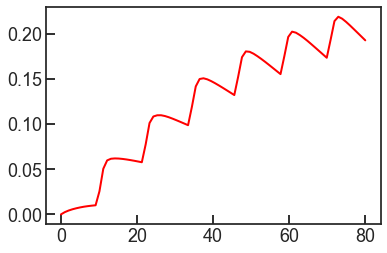

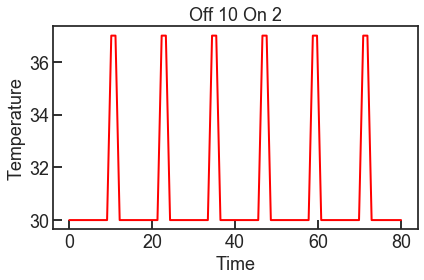

In [5]:
mfproduction = .35 #mf-Lon Production
mfdegradation = .32 #mf-Lon Degradation
msproduction = .35 #m-Scarlet production
msdegradation = .0256
inducedDegradation = 16.2*msdegradation
cIproduction = .45
cIdegradation = .0256
icIdegradation = 0
kd = .11
cIconcentration = 0.8
mfConcentration = 0
msConcentration = 0
time = np.linspace(0, 80, 80)
noise = np.random.normal(0, .1, len(time))
ht = hIFFL(mfproduction, mfdegradation, msproduction, msdegradation, inducedDegradation, cIproduction, cIdegradation, icIdegradation, kd)
rr = ht.runmodel(cIconcentration, 0, cIconcentration, mfConcentration, msConcentration, 0, time, 10, 2, noise)
plt.plot(time, rr[3])
plt.show()
plt.plot(time, rr[4])
plt.show()
plt.plot(time, rr[6])
plt.title("Off 10 On 2")
plt.ylabel("Temperature")
plt.xlabel("Time")
plt.tight_layout()
plt.savefig('Off10On2', dpi = 1000, quality = 100)
plt.show()

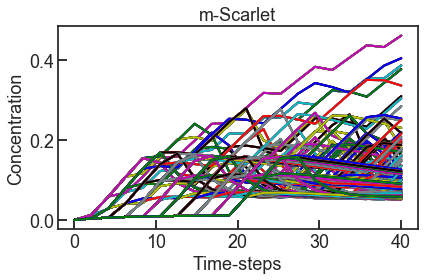

variance for each on time:  [0.014207131310281694, 0.020957100772124062, 0.0055939450492621424, 0.0037324386342881487, 0.0029891051672304094, 0.002041217282559144, 0.0018854165873714707, 0.0016307566434778347, 0.001614225147312697, 0.001595730910546349, 0.007100872896305111, 0.013186443332002544, 0.01543024595539741, 0.005837612908533191, 0.003692590775015665, 0.0027751507935161266, 0.002445490119425027, 0.002397471961550117, 0.0023706769365383976, 0.002360630797402369, 0.0045044199464685675, 0.008674773932181148, 0.012994394659203443, 0.006994611592756925, 0.003410756236688852, 0.002980216866428823, 0.0028560878749529575, 0.0028240266361954877, 0.0028393687375341766, 0.0028502987639749794, 0.0028689463455791194, 0.0069753588582621194, 0.009582419642735306, 0.006190481214140986, 0.003741348174569616, 0.003327749384942637, 0.0032370346408390886, 0.0032133532089966086, 0.002851564387253166, 0.0020933089726626235, 0.0024535422386544764, 0.004797690558018287, 0.008401792762828448, 0.006544

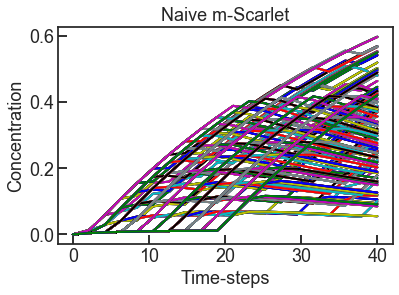

variance for each on time:  [0.2003505197735795, 0.2003505197735795, 0.2003505197735795, 0.2003505197735795, 0.2003505197735795, 0.2003505197735795, 0.2003505197735795, 0.2003505197735795, 0.2003505197735795, 0.2003505197735795, 0.2003505197735795, 0.2003505197735795, 0.2003505197735795, 0.2003505197735795, 0.2003505197735795, 0.2003505197735795, 0.2003505197735795, 0.2003505197735795, 0.2003505197735795, 0.2003505197735795, 0.2003505197735795, 0.2003505197735795, 0.2003505197735795, 0.2003505197735795, 0.2003505197735795, 0.2003505197735795, 0.2003505197735795, 0.2003505197735795, 0.2003505197735795, 0.2003505197735795, 0.2003505197735795, 0.2003505197735795, 0.2003505197735795, 0.2003505197735795, 0.2003505197735795, 0.2003505197735795, 0.2003505197735795, 0.2003505197735795, 0.2003505197735795, 0.2003505197735795, 0.2003505197735795, 0.2003505197735795, 0.2003505197735795, 0.2003505197735795, 0.2003505197735795, 0.2003505197735795, 0.2003505197735795, 0.2003505197735795, 0.200350519

In [7]:
mfproduction = .35 #mf-Lon Production
mfdegradation = .32 #mf-Lon Degradation
msproduction = .35 #m-Scarlet production
msdegradation = .0256
inducedDegradation = 16.2*msdegradation
cIproduction = .45
cIdegradation = .0256
icIdegradation = 0
kd = .11
cIconcentration = 0.8
mfConcentration = 0
msConcentration = 0
time = np.linspace(0, 40, 20)
tv = .35

ivar = []
finalvar = []
bk = []
prevarr = []
loop = []
off = 1
on = 1
noise = np.random.normal(0, .1, len(time))
while off <= 10:
    while on <= 10:
        tv = .35
        while tv <= 1: 
            ht = hIFFL(mfproduction, mfdegradation, tv, msdegradation, inducedDegradation, cIproduction, cIdegradation, icIdegradation, kd)
            rr = ht.runmodel(cIconcentration, 0, cIconcentration, mfConcentration, msConcentration, 0, time, off, on, noise)
            tv += 0.1
            plt.plot(time, rr[4])
            ivar.append(rr[4])
#         bk.append(rr[4])
        on += 1
        finalvar.append(np.var(ivar, dtype = np.float64))
        ivar = []
#     plt.fill_between(time, bk[0], bk[1], where=bk[0] <= bk[1], interpolate=True, color='yellow') #fill in only fills two graphs rn
#     plt.fill_between(time, bk[0], bk[1], where=bk[0] >= bk[1], interpolate=True, color='green') #fill in only fills two graphs rn   
    on = 1 
    off += 1
# area = abs(simps(bk[0], dx = 1) - simps(bk[1], dx = 1)) #Using simpson's rule to estimate area between graphs
#     loop.append(area)
plt.title('m-Scarlet')
plt.xlabel('Time-steps')
plt.ylabel('Concentration')
plt.tight_layout()
plt.savefig('parameterregions', quality = 100, dpi = 1000)
plt.show()
print("variance for each on time: ", finalvar)
print("variance for IFFL: ", np.mean(finalvar))
# print("shaded areas IFFL: ", area)

nvar = []
finalvar = []
bk1 = []
tv = .35
off = 1
on = 1
while off <= 10:
    while on <= 10:
        tv = .35
        while tv <= 1:   
            nai = naive(tv, msdegradation, cIproduction, cIdegradation, icIdegradation, kd)
            rn = nai.runmodel(cIconcentration, 0, cIconcentration, msConcentration, time, off, on, noise)
            tv += 0.1
            plt.plot(time, rn[3])
            nvar.append(rr[3])
        on += 1
        finalvar.append(np.var(nvar, dtype = np.float64))
#         bk1.append(rn[3])
        nvar = []
#     plt.fill_between(time, bk1[0], bk1[1], where=bk[0] <= bk[1], interpolate=True, color='yellow')
#     plt.fill_between(time, bk1[0], bk1[1], where=bk[0] >= bk[1], interpolate=True, color='green')
    on = 1
    off += 1
# area = abs(simps(bk1[0], dx = 1) - simps(bk1[1], dx = 1)) #Using simpson's rule to estimate area between graphs
plt.title('Naive m-Scarlet')
plt.xlabel('Time-steps')
plt.ylabel('Concentration')
plt.show()   
print("variance for each on time: ", finalvar)
print("variance for Naive: ", np.mean(finalvar))
# print("shaded areas Naive: ", area)


In [12]:
def Lorenz(IFFL, Naive):
    iT = 0
    nT = 0
    niA = []
    nnA= []
    siA = []
    snA = []
    for i in range(len(IFFL)):
        iT += IFFL[i]
        nT += Naive[i]
    for j in range(len(IFFL)):
        niA.append(IFFL[j]/iT)
        nnA.append(Naive[j]/nT)
    siA.append(niA[0])
    snA.append(nnA[0])
    for k in range(1, len(niA)):
        temp = niA[k] + siA[k-1]
        siA.append(temp)
        temp = nnA[k] + snA[k-1]
        snA.append(temp)
    return[siA, snA]

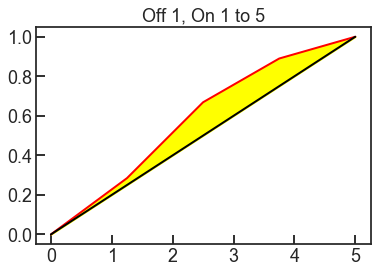

Gini:  0.04316130619597902


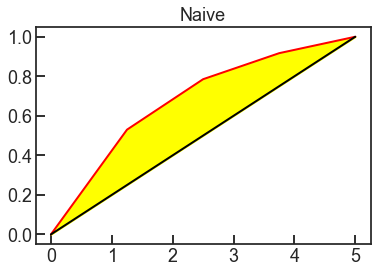

Gini:  0.09826266770218106


In [13]:
IFFL = [0, 1.0808006983322493, 1.4564090725944294, 0.8392428846340718, 0.4181002158063647]
Naive = [0, 1.150731916186805, 0.5541044995006992, 0.2860114684944719, 0.18030350870583156]
result = Lorenz(IFFL, Naive)
series = np.linspace(0, 5, 5)
equality = np.linspace(0, 1, 5)
plt.title("Off 1, On 1 to 5")
plt.plot(series, result[0])
plt.plot(series, equality)
plt.fill_between(series, result[0], equality, where=result[0] >= equality, interpolate=True, color='yellow') #fill in only fills two graphs rn
plt.fill_between(series, result[0], equality, where=result[0] <= equality, interpolate=True, color='green') #fill in only fills two graphs rn
plt.show()
print("Gini: ", abs(simps(result[0], np.linspace(0, 1, 5)) - 0.5)/2)
plt.title("Naive")
plt.plot(series, result[1])
plt.plot(series, equality)
plt.fill_between(series, result[1], equality, where=result[1] >= equality, interpolate=True, color='yellow') #fill in only fills two graphs rn
plt.fill_between(series, result[1], equality, where=result[1] <= equality, interpolate=True, color='green') #fill in only fills two graphs rn
plt.show()
print("Gini: ", abs(simps(result[1], np.linspace(0, 1, 5)) - 0.5)/2)

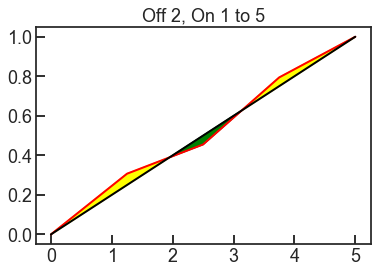

Gini:  0.013122488027589696


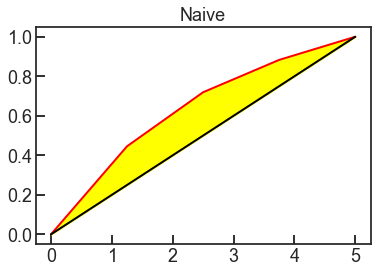

Gini:  0.07304462773936499


In [14]:
IFFL = [0, 1.1151586185723836,
0.537430554751456,
1.2314982200909617,
0.7475930090197784]
Naive = [0, 1.1151592637586947,
0.6842296031442383,
0.40956255820463383,
0.2929059261311364]
result = Lorenz(IFFL, Naive)
series = np.linspace(0, 5, 5)
equality = np.linspace(0, 1, 5)
plt.title("Off 2, On 1 to 5")
plt.plot(series, result[0])
plt.plot(series, equality)
plt.fill_between(series, result[0], equality, where=result[0] >= equality, interpolate=True, color='yellow') #fill in only fills two graphs rn
plt.fill_between(series, result[0], equality, where=result[0] <= equality, interpolate=True, color='green') #fill in only fills two graphs rn
plt.show()
print("Gini: ", abs(simps(result[0], np.linspace(0, 1, 5)) - 0.5)/2)
plt.title("Naive")
plt.plot(series, result[1])
plt.plot(series, equality)
plt.fill_between(series, result[1], equality, where=result[1] >= equality, interpolate=True, color='yellow') #fill in only fills two graphs rn
plt.fill_between(series, result[1], equality, where=result[1] <= equality, interpolate=True, color='green') #fill in only fills two graphs rn
plt.show()
print("Gini: ", abs(simps(result[1], np.linspace(0, 1, 5)) - 0.5)/2)

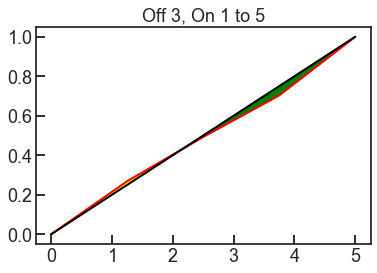

Gini:  0.005270820696747169


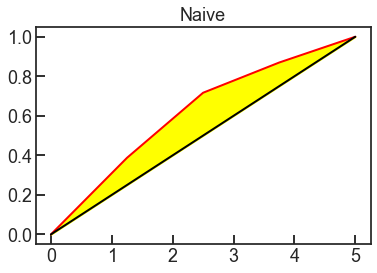

Gini:  0.06091548998188667


In [15]:
IFFL = [0, 0.891672276499933,
0.7435184247721356,
0.6985009486170668,
0.9846290850501296]
Naive = [0, 0.891672497120612,
0.7573651856276746,
0.35175948085137865,
0.3000414289505909]
result = Lorenz(IFFL, Naive)
series = np.linspace(0, 5, 5)
equality = np.linspace(0, 1, 5)
plt.title("Off 3, On 1 to 5")
plt.plot(series, result[0])
plt.plot(series, equality)
plt.fill_between(series, result[0], equality, where=result[0] <= equality, interpolate=True, color='green') #fill in only fills two graphs rn
plt.fill_between(series, result[0], equality, where=result[0] >= equality, interpolate=True, color='yellow') #fill in only fills two graphs rn
plt.show()
print("Gini: ", abs(simps(result[0], np.linspace(0, 1, 5)) - 0.5)/2)
plt.title("Naive")
plt.plot(series, result[1])
plt.plot(series, equality)
plt.fill_between(series, result[1], equality, where=result[1] <= equality, interpolate=True, color='green') #fill in only fills two graphs rn
plt.fill_between(series, result[1], equality, where=result[1] >= equality, interpolate=True, color='yellow') #fill in only fills two graphs rn
plt.show()
print("Gini: ", abs(simps(result[1], np.linspace(0, 1, 5)) - 0.5)/2)

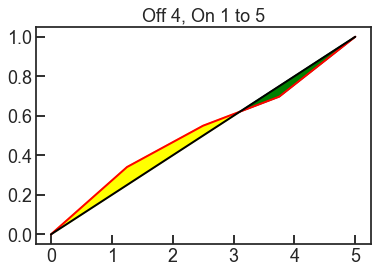

Gini:  0.01043213365761908


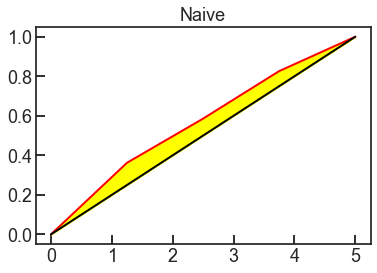

Gini:  0.0385965339502764


In [16]:
IFFL = [0, 0.805745322439531,
0.49454224097460070,
0.34706315947459965,
0.7168553145322101]
Naive = [0, 0.8057452561615301,
0.49666683262374134,
0.5345177063410378,
0.38629329510799110]
result = Lorenz(IFFL, Naive)
series = np.linspace(0, 5, 5)
equality = np.linspace(0, 1, 5)
plt.title("Off 4, On 1 to 5")
plt.plot(series, result[0])
plt.plot(series, equality)
plt.fill_between(series, result[0], equality, where=result[0] <= equality, interpolate=True, color='green') #fill in only fills two graphs rn
plt.fill_between(series, result[0], equality, where=result[0] >= equality, interpolate=True, color='yellow') #fill in only fills two graphs rn
plt.show()
print("Gini: ", abs(simps(result[0], np.linspace(0, 1, 5)) - 0.5)/2)
plt.title("Naive")
plt.plot(series, result[1])
plt.plot(series, equality)
plt.fill_between(series, result[1], equality, where=result[1] <= equality, interpolate=True, color='green') #fill in only fills two graphs rn
plt.fill_between(series, result[1], equality, where=result[1] >= equality, interpolate=True, color='yellow') #fill in only fills two graphs rn
plt.show()
print("Gini: ", abs(simps(result[1], np.linspace(0, 1, 5)) - 0.5)/2)

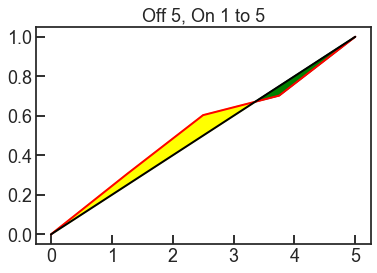

Gini:  0.00992401494190931


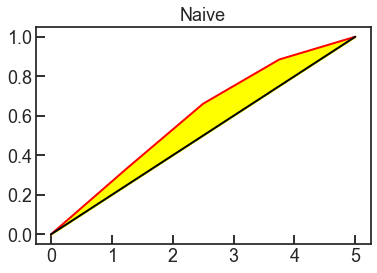

Gini:  0.049977290082478754


In [138]:
IFFL = [0, 0.6232078186716163,
0.6073848791299046,
0.20140673518607244,
0.607262644298207]
Naive = [0, 0.6232078691302165,
0.6083116412234064,
0.4166721505371118,
0.2146555106134458]
result = Lorenz(IFFL, Naive)
series = np.linspace(0, 5, 5)
equality = np.linspace(0, 1, 5)
plt.title("Off 5, On 1 to 5")
plt.plot(series, result[0])
plt.plot(series, equality)
plt.fill_between(series, result[0], equality, where=result[0] <= equality, interpolate=True, color='green') #fill in only fills two graphs rn
plt.fill_between(series, result[0], equality, where=result[0] >= equality, interpolate=True, color='yellow') #fill in only fills two graphs rn
plt.show()
print("Gini: ", abs(simps(result[0], np.linspace(0, 1, 5)) - 0.5)/2)
plt.title("Naive")
plt.plot(series, result[1])
plt.plot(series, equality)
plt.fill_between(series, result[1], equality, where=result[1] <= equality, interpolate=True, color='green') #fill in only fills two graphs rn
plt.fill_between(series, result[1], equality, where=result[1] >= equality, interpolate=True, color='yellow') #fill in only fills two graphs rn
plt.show()
print("Gini: ", abs(simps(result[1], np.linspace(0, 1, 5)) - 0.5)/2)

In [29]:

import plotly.plotly as py
from plotly.graph_objs import *
py.sign_in('username', 'api_key')
trace1 = {
  "x": ["Off", "1", "1", "1", "1", "2", "2", "2", "2", "3", "3", "3", "3", "4", "4", "4", "4", "5", "5", "5", "5"], 
  "y": ["On", "1 to 2", "2 to 3", "3 to 4", "4 to 5", "1 to 2", "2 to 3", "3 to 4", "4 to 5", "1 to 2", "2 to 3", "3 to 4", "4 to 5", "1 to 2", "2 to 3", "3 to 4", "4 to 5", "1 to 2", "2 to 3", "3 to 4", "4 to 5"], 
  "z": ["IFFL Area Difference", "1.0808006983322493", "1.4564090725944294", "0.8392428846340718", "0.4181002158063647", "1.1151586185723836", "0.537430554751456", "1.2314982200909617", "0.7475930090197784", "0.891672276499933", "0.7435184247721356", "0.6985009486170668", "0.9846290850501296", "0.805745322439531", "0.49454224097460070", "0.34706315947459965", "0.7168553145322101", "0.6232078186716163", "0.6073848791299046", "0.20140673518607244", "0.607262644298207"], 
  "autocolorscale": False, 
  "cauto": True, 
  "cmax": 1.45640907259, 
  "cmin": 0.201406735186, 
  "colorbar": {
    "x": 0.847366746221, 
    "y": 0.470961887477, 
    "title": "IFFL"
  }, 
  "colorscale": [
    [0, "#440154"], [0.111111111111, "#482878"], [0.222222222222, "#3e4989"], [0.333333333333, "#31688e"], [0.444444444444, "#26828e"], [0.555555555556, "#1f9e89"], [0.666666666667, "#35b779"], [0.777777777778, "#6ece58"], [0.888888888889, "#b5de2b"], [1, "#fde725], 
  "facecolor": ["IFFL Area Difference", "1.0808006983322493", "1.4564090725944294", "0.8392428846340718", "0.4181002158063647", "1.1151586185723836", "0.537430554751456", "1.2314982200909617", "0.7475930090197784", "0.891672276499933", "0.7435184247721356", "0.6985009486170668", "0.9846290850501296", "0.805745322439531", "0.49454224097460070", "0.34706315947459965", "0.7168553145322101", "0.6232078186716163", "0.6073848791299046", "0.20140673518607244", "0.607262644298207"], 
  "facecolorsrc": "thson:13:3a7cd5", 
  "intensity": ["IFFL Area Difference", "1.0808006983322493", "1.4564090725944294", "0.8392428846340718", "0.4181002158063647", "1.1151586185723836", "0.537430554751456", "1.2314982200909617", "0.7475930090197784", "0.891672276499933", "0.7435184247721356", "0.6985009486170668", "0.9846290850501296", "0.805745322439531", "0.49454224097460070", "0.34706315947459965", "0.7168553145322101", "0.6232078186716163", "0.6073848791299046", "0.20140673518607244", "0.607262644298207"], 
  "intensitysrc": "thson:13:3a7cd5", 
  "type": "mesh3d", 
  "vertexcolor": ["IFFL Area Difference", "1.0808006983322493", "1.4564090725944294", "0.8392428846340718", "0.4181002158063647", "1.1151586185723836", "0.537430554751456", "1.2314982200909617", "0.7475930090197784", "0.891672276499933", "0.7435184247721356", "0.6985009486170668", "0.9846290850501296", "0.805745322439531", "0.49454224097460070", "0.34706315947459965", "0.7168553145322101", "0.6232078186716163", "0.6073848791299046", "0.20140673518607244", "0.607262644298207"], 
  "vertexcolorsrc": "thson:13:3a7cd5", 
  "xsrc": "thson:13:a48a45", 
  "ysrc": "thson:13:258c66", 
  "zsrc": "thson:13:3a7cd5"
}
trace2 = {
  "x": ["Off", "1", "1", "1", "1", "2", "2", "2", "2", "3", "3", "3", "3", "4", "4", "4", "4", "5", "5", "5", "5"], 
  "y": ["On", "1 to 2", "2 to 3", "3 to 4", "4 to 5", "1 to 2", "2 to 3", "3 to 4", "4 to 5", "1 to 2", "2 to 3", "3 to 4", "4 to 5", "1 to 2", "2 to 3", "3 to 4", "4 to 5", "1 to 2", "2 to 3", "3 to 4", "4 to 5"], 
  "z": ["Naive Area Difference", "1.150731916186805", "0.5541044995006992", "0.2860114684944719", "0.18030350870583156", "1.1151592637586947", "0.6842296031442383", "0.40956255820463383", "0.2929059261311364", "0.891672497120612", "0.7573651856276746", "0.35175948085137865", "0.3000414289505909", "0.8057452561615301", "0.49666683262374134", "0.5345177063410378", "0.38629329510799110", "0.6232078691302165", "0.6083116412234064", "0.4166721505371118", "0.2146555106134458"], 
  "autocolorscale": False, 
  "cauto": True, 
  "cmax": 1.15073191619, 
  "cmin": 0.180303508706, 
  "colorbar": {
    "x": 0.16987076264, 
    "y": 0.458257713249, 
    "title": "Naive"
  }, 
  "colorscale": [
    [0, "#fff7f3"], [0.125, "#fde0dd"], [0.25, "#fcc5c0"], [0.375, "#fa9fb5"], [0.5, "#f768a1"], [0.625, "#dd3497"], [0.75, "#ae017e"], [0.875, "#7a0177"], [1, "#49006a], 
  "facecolor": ["Naive Area Difference", "1.150731916186805", "0.5541044995006992", "0.2860114684944719", "0.18030350870583156", "1.1151592637586947", "0.6842296031442383", "0.40956255820463383", "0.2929059261311364", "0.891672497120612", "0.7573651856276746", "0.35175948085137865", "0.3000414289505909", "0.8057452561615301", "0.49666683262374134", "0.5345177063410378", "0.38629329510799110", "0.6232078691302165", "0.6083116412234064", "0.4166721505371118", "0.2146555106134458"], 
  "facecolorsrc": "thson:13:28cb59", 
  "intensity": ["Naive Area Difference", "1.150731916186805", "0.5541044995006992", "0.2860114684944719", "0.18030350870583156", "1.1151592637586947", "0.6842296031442383", "0.40956255820463383", "0.2929059261311364", "0.891672497120612", "0.7573651856276746", "0.35175948085137865", "0.3000414289505909", "0.8057452561615301", "0.49666683262374134", "0.5345177063410378", "0.38629329510799110", "0.6232078691302165", "0.6083116412234064", "0.4166721505371118", "0.2146555106134458"], 
  "intensitysrc": "thson:13:28cb59", 
  "type": "mesh3d", 
  "vertexcolor": ["Naive Area Difference", "1.150731916186805", "0.5541044995006992", "0.2860114684944719", "0.18030350870583156", "1.1151592637586947", "0.6842296031442383", "0.40956255820463383", "0.2929059261311364", "0.891672497120612", "0.7573651856276746", "0.35175948085137865", "0.3000414289505909", "0.8057452561615301", "0.49666683262374134", "0.5345177063410378", "0.38629329510799110", "0.6232078691302165", "0.6083116412234064", "0.4166721505371118", "0.2146555106134458"], 
  "vertexcolorsrc": "thson:13:28cb59", 
  "xsrc": "thson:13:a48a45", 
  "ysrc": "thson:13:258c66", 
  "zsrc": "thson:13:28cb59"
}
data = Data([trace1, trace2])
layout = {
  "autosize": True, 
  "colorway": ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"], 
  "dragmode": "zoom", 
  "hovermode": "closest", 
  "legend": {
    "x": 0.704571735009, 
    "y": 0.701104772642
  }, 
  "polar": {"radialaxis": {
      "autorange": True, 
      "range": [0, 1]
    }}, 
  "scene": {
    "aspectmode": "auto", 
    "aspectratio": {
      "x": 1.11803398875, 
      "y": 0.894427191, 
      "z": 1
    }, 
    "camera": {
      "center": {
        "x": -0.14594740823, 
        "y": -0.296362661402, 
        "z": -0.385829806389
      }, 
      "eye": {
        "x": 1.23869880302, 
        "y": 1.17511061436, 
        "z": 1.36498316907
      }, 
      "up": {
        "x": 0, 
        "y": 0, 
        "z": 1
      }
    }, 
    "dragmode": "turntable", 
    "xaxis": {
      "autorange": True, 
      "nticks": 16, 
      "tickmode": "auto", 
      "title": "Off", 
      "type": "category"
    }, 
    "yaxis": {
      "title": "On", 
      "type": "category"
    }, 
    "zaxis": {
      "autorange": True, 
      "dtick": 0.1, 
      "exponentformat": "000", 
      "nticks": 0, 
      "range": [-9.9999, 0.001], 
      "separatethousands": False, 
      "showticklabels": True, 
      "tick0": 2, 
      "tickmode": "auto", 
      "tickprefix": "", 
      "title": "Area Difference", 
      "type": "log"
    }
  }, 
  "showlegend": True, 
  "title": "Area Difference With Respect to Consecutive On Ratio", 
  "titlefont": {"size": 17}, 
  "xaxis": {
    "autorange": True, 
    "range": [-0.5, 5.5], 
    "type": "linear"
  }, 
  "yaxis": {
    "autorange": True, 
    "range": [-0.5, 5.5], 
    "type": "linear"
  }
}
fig = Figure(data=data, layout=layout)
plot_url = py.plot(fig)

SyntaxError: EOL while scanning string literal (<ipython-input-29-b1c1968b9642>, line 19)